In [1]:
%matplotlib inline
import numpy as np
import sys 
import json
import seaborn as sns
import pandas as pd
import os
import glob
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
sns.set_style("whitegrid")
sys.path.append('../')
from src.utils import save_json, subfiles, join, maybe_mkdir_p, reconstruct_seg_df_from_json, reconstruct_calib_df_from_json, reconstruct_UED_df_from_json

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.distributions as td

import numpy as np
import math 
from typing import Tuple
from matplotlib import pyplot as plt
import cupy as cp

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
## directorys for internal  probability maps 

DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"

studies = [
join(NNUNET_PMAPS,'f0_tta'),
join(NNUNET_PMAPS,'f0'),
join(DROP2_PMAPS,'f0_mc10_tta')
,join(NNUNET_PMAPS,'f01234_tta')
,join(DROP2_PMAPS,'f0_tta_snap')
,join(DROP2_PMAPS,'f01234_mc10_tta_snap')
,join(PH_PMAPS,'f01234_tta')
]

groud_truth = '/data/jintao/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task901_AUH/labelsTs/'

groups = ['Baseline','No TTA', 'MC Dropout','Ensemble','Snapshots', "Complex" ,'PhiSeg']


In [37]:
import time

def _calculate_ece(confidences, predictions, labels, n_bins=10):
    """
    Calculates the Expected Calibration Error of a model.
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """

    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    #softmaxes = np.softmax(logits, dim=1)
    #confidences, predictions = outputs.max(0), outputs.argmax(0)
    confidences = confidences
    predictions = predictions
    
    accuracies = np.equal(predictions, labels)

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = np.greater(confidences, bin_lower.item()) * np.less_equal(confidences,bin_upper.item())
        prop_in_bin = in_bin.mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece.item()


def compute_acc_bin(conf_thresh_lower, conf_thresh_upper, conf, pred, true):
    """
    # Computes accuracy and average confidence for bin
    
    Args:
        conf_thresh_lower (float): Lower Threshold of confidence interval
        conf_thresh_upper (float): Upper Threshold of confidence interval
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels
    
    Returns:
        (accuracy, avg_conf, len_bin): accuracy of bin, confidence of bin and number of elements in bin.
    """
    filtered_tuples = [x for x in zip(pred, true, conf) if x[2] > conf_thresh_lower and x[2] <= conf_thresh_upper]
    if len(filtered_tuples) < 1:
        return 0,0,0
    else:
        correct = len([x for x in filtered_tuples if x[0] == x[1]])  # How many correct labels
        len_bin = len(filtered_tuples)  # How many elements falls into given bin
        avg_conf = sum([x[2] for x in filtered_tuples]) / len_bin  # Avg confidence of BIN
        accuracy = float(correct)/len_bin  # accuracy of BIN
        return accuracy, avg_conf, len_bin


def calcualte_ece_simple(conf, pred, true, bin_size=0.1):
    print("calculating ece using simple")
    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)  # Get bounds of bins
    n = len(conf)
    ece = 0  # Starting error
    
    for conf_thresh in upper_bounds:  # Go through bounds and find accuracies and confidences
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh-bin_size, conf_thresh, conf, pred, true)        
        ece += np.abs(acc-avg_conf)*len_bin/n  # Add weigthed difference to ECE
    return ece

def calculate_ece(predictions, labels, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(predictions, bin_boundaries) - 1

    ece = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if bin_mask.sum() > 0:
            accuracy = (labels[bin_mask] == (predictions[bin_mask] >= 0.5)).mean()
            confidence = predictions[bin_mask].mean()
            bin_prob = bin_mask.mean()
            ece += bin_prob * abs(accuracy - confidence)

    return ece
    
def make_model_diagrams(outputs, labels, confidences, ax=None, n_bins=10):

    print(outputs.shape, labels.shape)

    #predictions = (outputs > 0.5).astype(int)
    predictions = np.argmax(outputs,axis=0).astype(int) # udpate binary to multi-class
    accuracies = np.equal(predictions, labels)

    #overall_accuracy = (predictions==labels).sum().item()/len(labels)
    
    # Reliability diagram
    bins = np.linspace(0, 1, n_bins + 1)
    width = 1.0 / n_bins
    bin_centers = np.linspace(0, 1.0 - width, n_bins) + width / 2
    #bin_indices = [confidences.ge(bin_lower) * confidences.lt(bin_upper) for bin_lower, bin_upper in zip(bins[:-1], bins[1:])]
    bin_indices = [np.greater_equal(confidences, bin_lower) * np.less(confidences, bin_upper) for bin_lower, bin_upper in zip(bins[:-1], bins[1:])]
    

    bin_corrects = np.array([ np.mean(accuracies[bin_index]) for bin_index in bin_indices])
    bin_scores = np.array([ np.mean(confidences[bin_index]) for bin_index in bin_indices])
    bin_corrects = np.nan_to_num(bin_corrects)
    bin_scores = np.nan_to_num(bin_scores)


    gap = np.array(bin_scores - bin_corrects)

    confs = ax.bar(bin_centers, bin_corrects, color=[0, 0.24, 0.65], width=width, ec='black')

    bin_corrects = np.nan_to_num(np.asarray([bin_correct for bin_correct in bin_corrects]))
    gaps = ax.bar(bin_centers, gap, bottom=bin_corrects, color=[0.78, 0.06, 0.18], alpha=0.5, width=width, hatch='\/\/', edgecolor='r')

    ax.plot([0, 1], [0, 1], '--', color='gray')
    ax.legend([confs, gaps], ['Accuracy', 'Gap'], loc='upper left', fontsize='22') #xx-large # Increase fontsize here

    a = time.time()
    #ece = _calculate_ece(confidences, predictions, labels)
    ece = calcualte_ece_simple(confidences, predictions, labels)
    print(f"ece calculation time: {time.time()-a}")
    bbox_props = dict(boxstyle="square", fc="white", ec="gray", lw=1.5)
    #bbox_props = dict(boxstyle="square", fc="white", ec="white", lw=1.5)
    ax.text(0.15, 0.75, "ECE: {:.2f}".format(ece), ha="center", va="center", size=22, weight='normal', bbox=bbox_props)  # Increase size here

    # ax.title("Reliability Diagram", size=22) 
    ax.set_ylabel("Accuracy", size=25)  
    ax.set_xlabel("Confidence", size=25) 
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    return ece


def set_ROI(prob, true, label=False):
        """
        Set region of interest (ROI) for all channels. 
        """
        
        ROI = None
        if not label:
            roi_test =  1 - prob[0] 
            roi_test = roi_test * (roi_test>0.1).astype(int)
            try:
                roi_ref = true>0
            except IndexError:
                return []
            #roi_ref = roi_test
            #if roi_test.sum() < 100: ## if predicted roi_test smaller than 100 mm3 return nan
        else:
            roi_test = prob[label, : ]
            roi_test = roi_test * (roi_test>0.1).astype(int)
            
            try:
                roi_ref = (true==label).astype(int)
            except IndexError:
                return []
            
        #print("np.unique(roi_ref)", np.unique(roi_ref))
        assert (roi_test.shape==roi_ref.shape), f'ROI of reference and test not match! ({roi_test.shape} vs {roi_ref.shape})'

        ROI = (roi_test+roi_ref)>0

        print(f"ROI shapes {ROI.shape}, total ROI number: {np.sum(ROI)}")

        return ROI 

Baseline
['/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs/f0_tta/HNCDL_003.npz', '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs/f0_tta/HNCDL_007.npz', '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs/f0_tta/HNCDL_010.npz', '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs/f0_tta/HNCDL_011.npz', '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs/f0_tta/HNCDL_034.npz', '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs/f0_tta/HNCDL_045.npz', '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNet

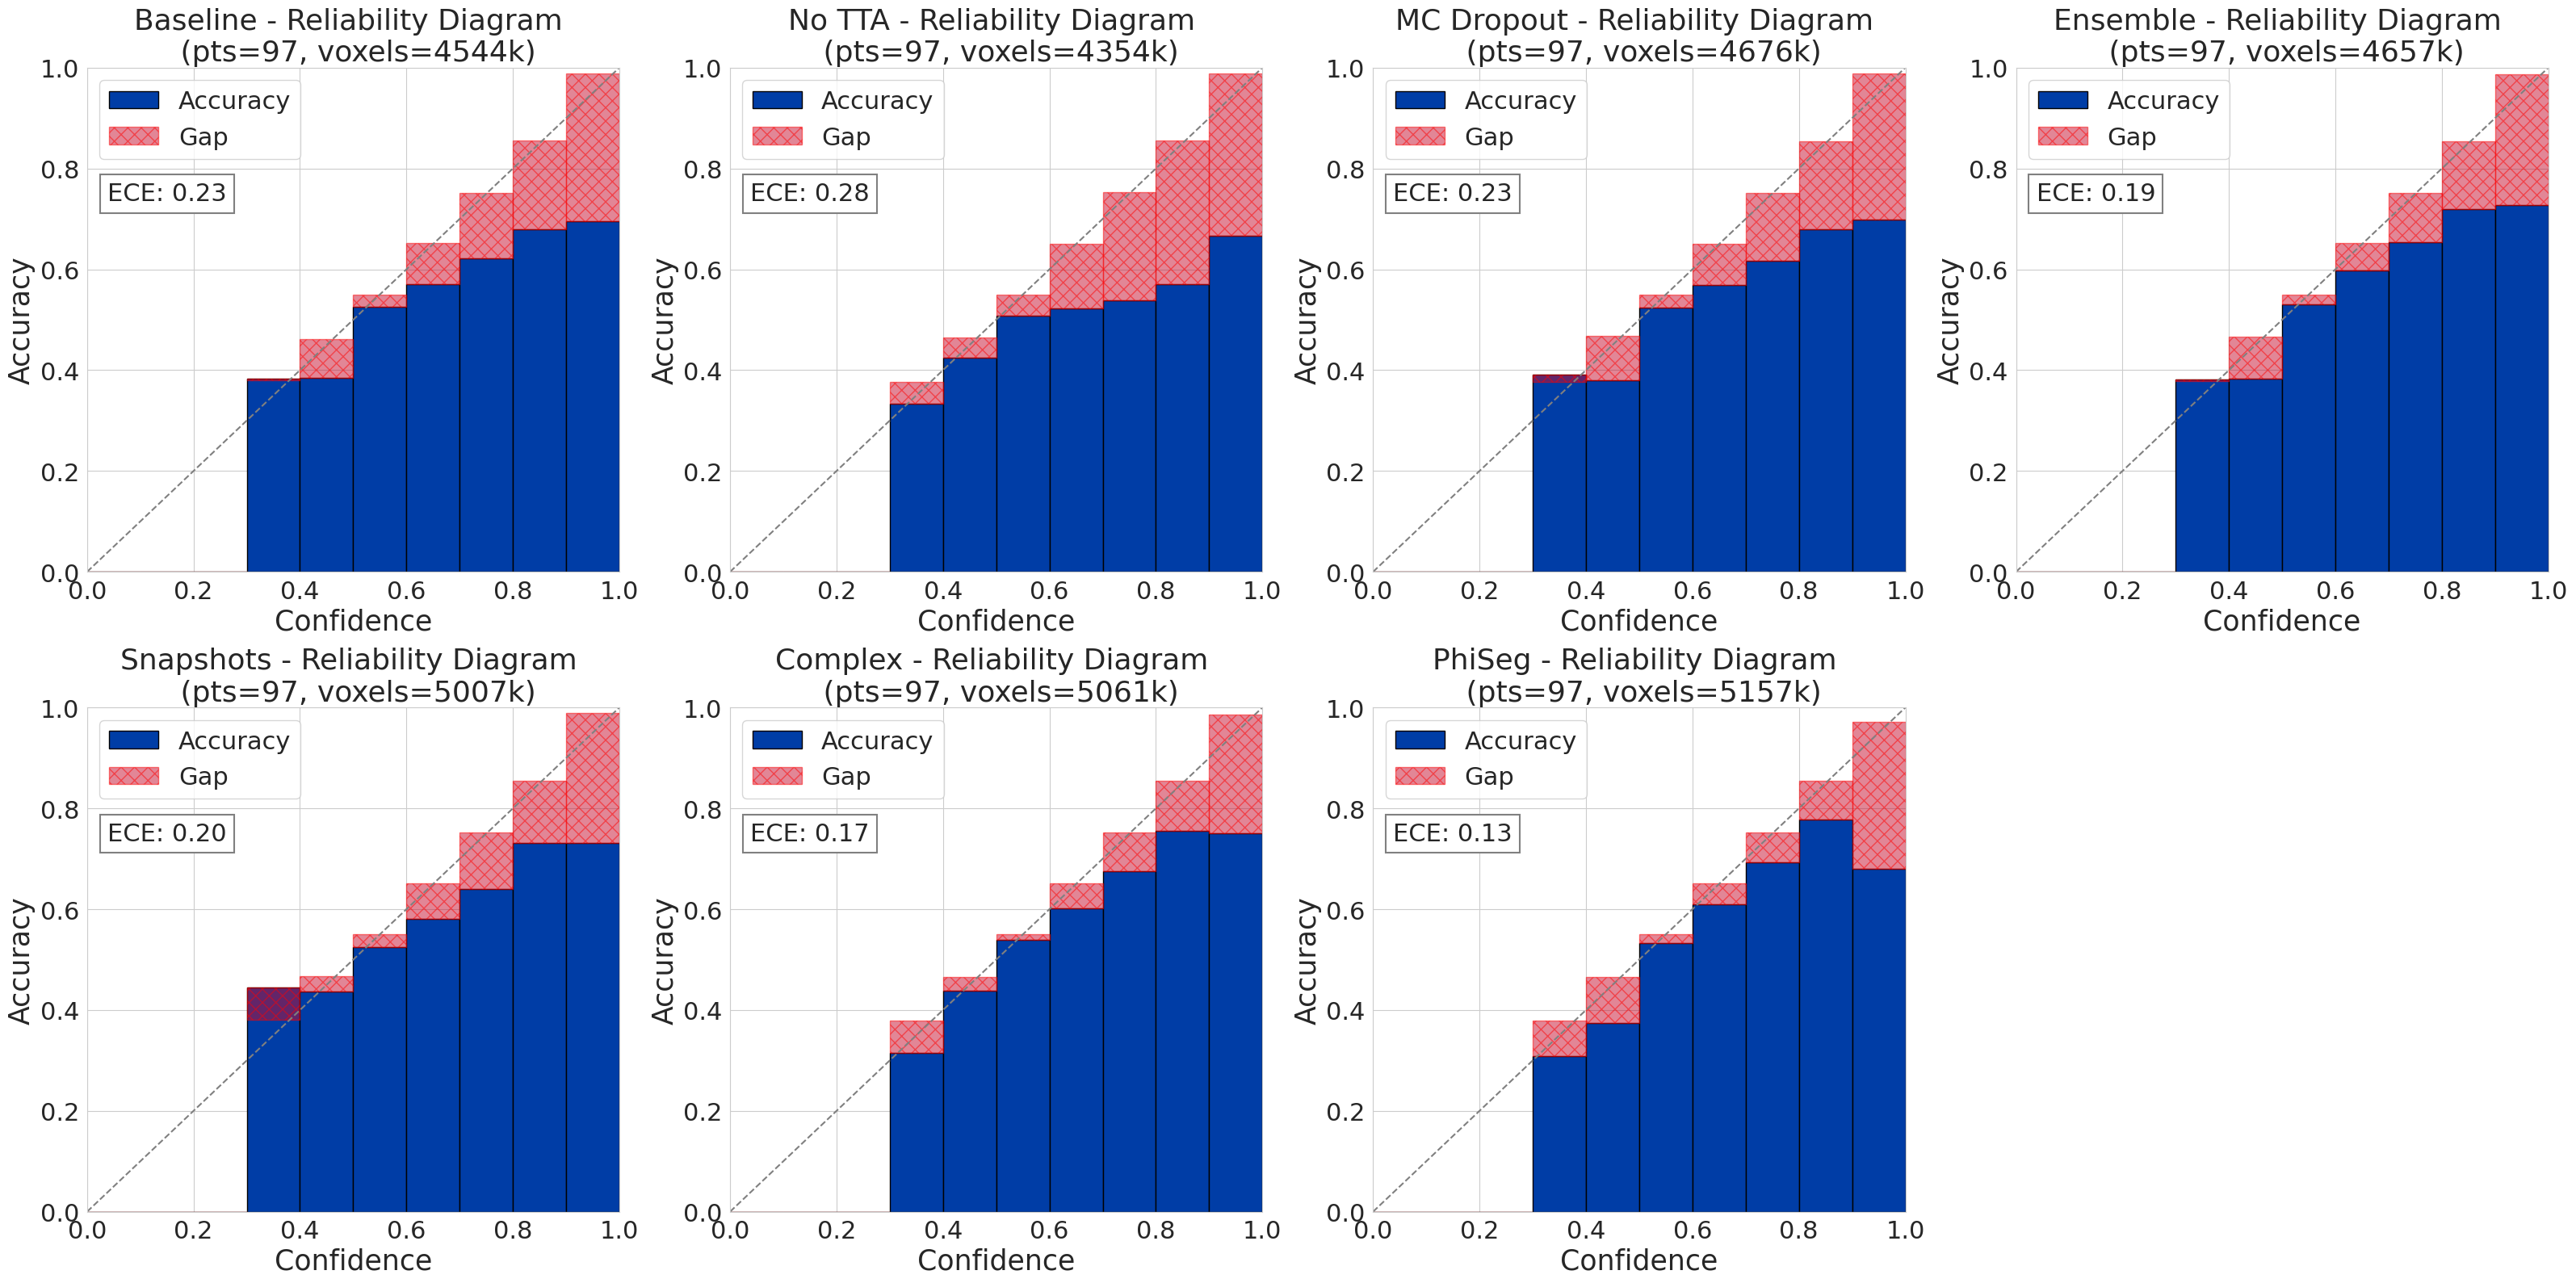

In [41]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
#To aggregate the data from all patients and plot a single reliability diagram 

groups = ['Baseline','No TTA', 'MC Dropout','Ensemble','Snapshots', "Complex" ,'PhiSeg']

def load_data(path):
    return np.load(path)['softmax']

def load_image(path):
    return sitk.GetArrayFromImage(sitk.ReadImage(path))


# # Using ProcessPoolExecutor
# def load_all_data(paths):
#     with ProcessPoolExecutor() as executor:
#         return list(executor.map(load_data, paths))

# def load_all_images(paths):
#     with ProcessPoolExecutor() as executor:
#         return list(executor.map(load_image, paths))


# all_probs_s, all_trues_s = [], []
# all_probs_t, all_trues_t = [], []
# all_probs_n, all_trues_n = [], []

# conf_s, conf_t, conf_n = [], [], []

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(8 * 4, 8 * 2)) 
axes_flat = axes.flatten()

for i, study in enumerate(groups): 
    print(study)
    softmax_patients_paths = sorted(glob.glob(os.path.join(studies[i], '*.npz')))
    groud_truth_path = sorted(glob.glob(os.path.join(groud_truth, '*.nii.gz')))
    print(softmax_patients_paths)
    print(groud_truth_path)
    with ThreadPoolExecutor() as executor:
        probs = list(executor.map(load_data, softmax_patients_paths))
        trues = list(executor.map(load_image, groud_truth_path))

    # probs = load_all_data(softmax_patients_paths)
    # trues = load_all_images(groud_truth_path)

    all_probs_s, all_trues_s = [], []
    all_probs_t, all_trues_t = [], []
    all_probs_n, all_trues_n = [], []

    conf_s, conf_t, conf_n = [], [], []

    for prob, true in zip(probs, trues):
        conf = prob.max(0)
        print(conf.shape)
        # GTV-S
        print(f"prob and true shape: {prob.shape}, prob.max {prob.max()}, {true.shape}, {true.max()}" )
        ROI = set_ROI(prob, true, label=False)
        #gtv_s_prob = prob #1 - prob[0,:] 
        #print(ROI.shape, gtv_s_prob.shape)
        reshaped_array = prob[:, ROI].reshape(3, -1)
        print(reshaped_array.shape)
        all_probs_s.append(reshaped_array)
        #all_probs_s.extend(gtv_s_prob[:,ROI])

        all_trues_s.extend((true)[ROI])
        #continue
        conf_s.extend(conf[ROI])
        
        print(len(all_probs_s), len(all_trues_s), len(conf_s))
        #all_probs_s = np.concatenate(all_probs_s, axis=1)

    all_probs_s = np.concatenate(all_probs_s, axis=1)
    print(f"all_probs_s.shape",  all_probs_s.shape)
    all_trues_s = np.asarray(all_trues_s)
    #continue
    conf_s = np.asarray(conf_s)

    print(all_trues_s.max(), np.argmax(all_probs_s,axis=0).max())

    ece_s = make_model_diagrams(np.asarray(all_probs_s), np.asarray(all_trues_s), conf_s, ax=axes_flat[i])
    axes_flat[i].set_title(f"{study} - Reliability Diagram \n (pts=97, voxels={int(len(all_trues_s)/1000)}k)", size=26)

for j in range(len(groups), 8):
    axes_flat[j].axis('off')

plt.tight_layout() 
plt.savefig('../figures/reliabiligy_diagram.svg', dpi=300)  
plt.show() 
